In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

from statsmodels.tsa.stattools import adfuller
#!pip install pmdarima --quiet
import pmdarima as pm
import pickle

#Import dataframe
from Dash.app_dataframe import df_hom

In [115]:
df = df_hom[['fecha','cantidad']]
df = df.set_index('fecha')
#Check montly
df = df.resample('W').sum()
df.columns = ['total']

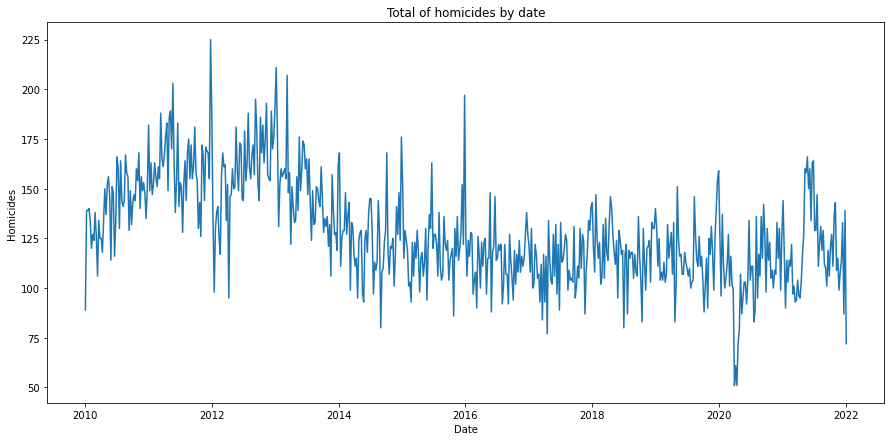

In [116]:
# Plot original timeserie
plt.figure(figsize=(15,7))
plt.title("Total of homicides by date")
plt.xlabel('Date')
plt.ylabel('Homicides')
plt.plot(df)
plt.show()

Text(0.5, 1.0, 'Rolling Mean & Standard Deviation')

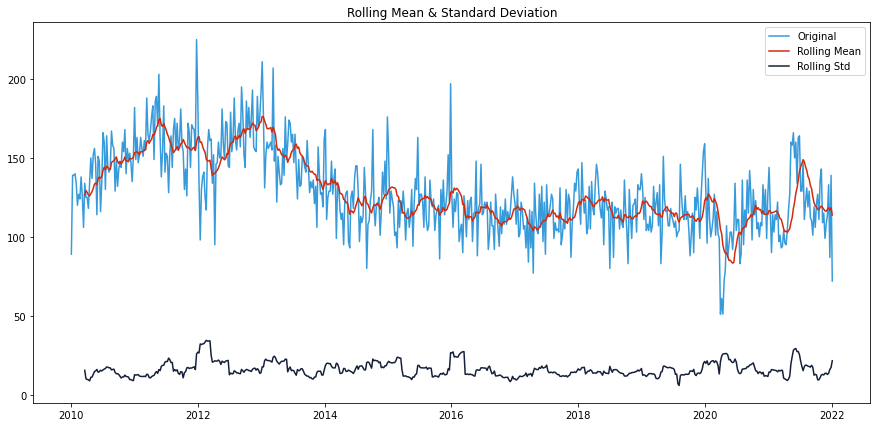

In [117]:
#Determine rolling statistics
df_p = df.copy()
df_p["rolling_avg"] = df["total"].rolling(window=12).mean()
df_p["rolling_std"] = df["total"].rolling(window=12).std()

#Plot rolling statistics
plt.figure(figsize=(15,7))
plt.plot(df_p["total"], color='#379BDB', label='Original')
plt.plot(df_p["rolling_avg"], color='#D22A0D', label='Rolling Mean')
plt.plot(df_p["rolling_std"], color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')

In [118]:
#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df['total'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                  -2.254544
p-value                          0.187048
#Lags Used                      12.000000
Number of Observations Used    614.000000
Critical Value (1%)             -3.441045
Critical Value (5%)             -2.866259
Critical Value (10%)            -2.569283
dtype: float64


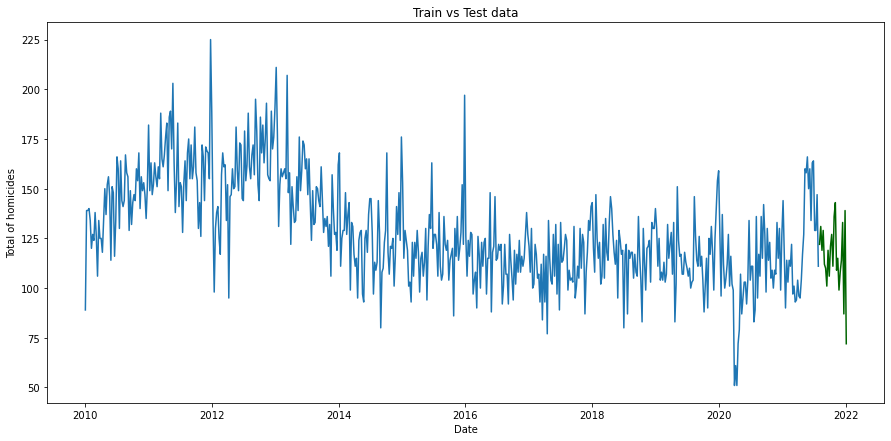

In [119]:
# Split data between train and test
train = df[df.index <= '2021-07-31']
test = df[df.index >= '2021-07-31']

plt.figure(figsize=(15,7))
plt.plot(train["total"], color='#1f76b4')
plt.plot(test["total"], color='darkgreen')

plt.xlabel('Date')
plt.ylabel('Total of homicides')
plt.title("Train vs Test data")
plt.show()

In [126]:
#adding exogenous variable
df['month_index'] = df.index.week
# Split data between train and test
train = df[(df.index <= '2021-07-31')]
test = df[df.index >= '2021-07-31']
#print(train.tail(10))
#print(test.head(30))

C:\Users\beale\AppData\Local\Temp\ipykernel_24264\2552258335.py:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['month_index'] = df.index.week


In [127]:
# Training SARIMAX Model
SARIMAX_model = pm.auto_arima(train['total'],
                           start_p=0, start_q=0,
                           test='adf',
                           max_p=8, max_q=8, #m=12,
                           start_P=0, seasonal=False,
                           d=None, D=1, 
                           trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=7610.831, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=5420.683, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=6961.632, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=5191.969, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=5185.720, Time=0.14 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=5183.571, Time=0.18 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=5183.038, Time=0.26 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=5181.714, Time=0.39 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(6,0,1)(0,0,0)[0]             : AIC=5182.894, Time=0.47 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=5181.343, Time=0.47 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=inf, Time=0

C:\Users\beale\AppData\Local\Temp\ipykernel_24264\720565583.py:5: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  forecast_df = pd.DataFrame({"month_index":pd.date_range(train.index[-1],


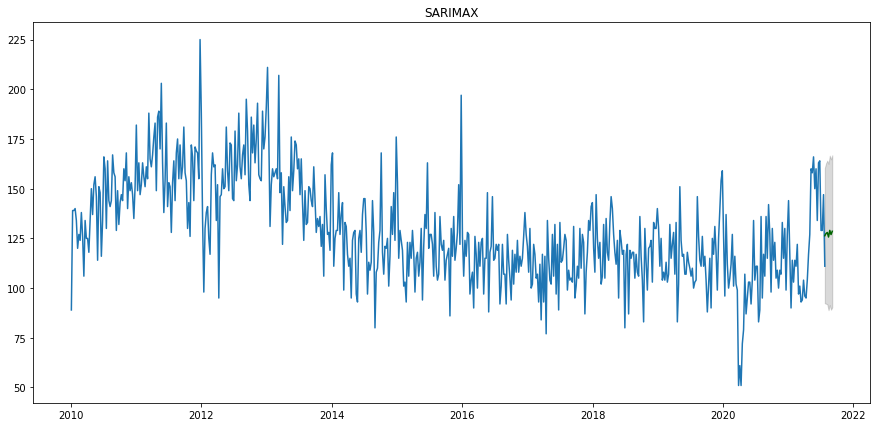

[126.33032822 127.44812646 127.98047183 125.69092287 129.02258123
 126.92986378 128.58389388]


In [128]:
def sarimax_forecast(SARIMAX_model, periods):
    # Forecast
    n_periods = periods

    forecast_df = pd.DataFrame({"month_index":pd.date_range(train.index[-1], 
                                periods = n_periods, 
                                freq='W').week},
                                index = pd.date_range(train.index[-1], 
                                        periods = n_periods, 
                                        freq='W'))

    fitted, confint = SARIMAX_model.predict(n_periods=n_periods, 
                                            return_conf_int=True,
                                            dynamic=True)

    index_of_fc = pd.date_range(train.index[-1], periods = n_periods, freq='W')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(train["total"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
   # plt.plot(df["total"], color='black')
    #plt.plot(test["total"], color='blue')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)
    
    plt.title("SARIMAX")
    plt.show()

    print(fitted)

sarimax_forecast(SARIMAX_model,7)

In [129]:
# Training SARIMAX Model
SARIMAX_model = pm.auto_arima(df['total'], exogenous=df[['month_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=4, max_q=4, m=24,
                           start_P=0, seasonal=True,
                           d=None, D=1, 
                           trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[24] intercept   : AIC=inf, Time=3.97 sec
 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=5616.550, Time=0.18 sec
 ARIMA(1,0,0)(1,1,0)[24] intercept   : AIC=5454.977, Time=2.71 sec
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=inf, Time=5.04 sec
 ARIMA(0,0,0)(0,1,0)[24]             : AIC=5615.178, Time=0.47 sec
 ARIMA(1,0,0)(0,1,0)[24] intercept   : AIC=5566.575, Time=0.58 sec
 ARIMA(1,0,0)(2,1,0)[24] intercept   : AIC=5408.705, Time=6.42 sec
 ARIMA(1,0,0)(2,1,1)[24] intercept   : AIC=inf, Time=15.77 sec
 ARIMA(1,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=5.00 sec
 ARIMA(0,0,0)(2,1,0)[24] intercept   : AIC=5487.519, Time=5.05 sec
 ARIMA(2,0,0)(2,1,0)[24] intercept   : AIC=5380.784, Time=7.73 sec
 ARIMA(2,0,0)(1,1,0)[24] intercept   : AIC=5428.390, Time=3.02 sec
 ARIMA(2,0,0)(2,1,1)[24] intercept   : AIC=inf, Time=8.07 sec
 ARIMA(2,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=2.87 sec
 ARIMA(3,0,0)(2,1,0)[24] intercept   : AIC=5372.

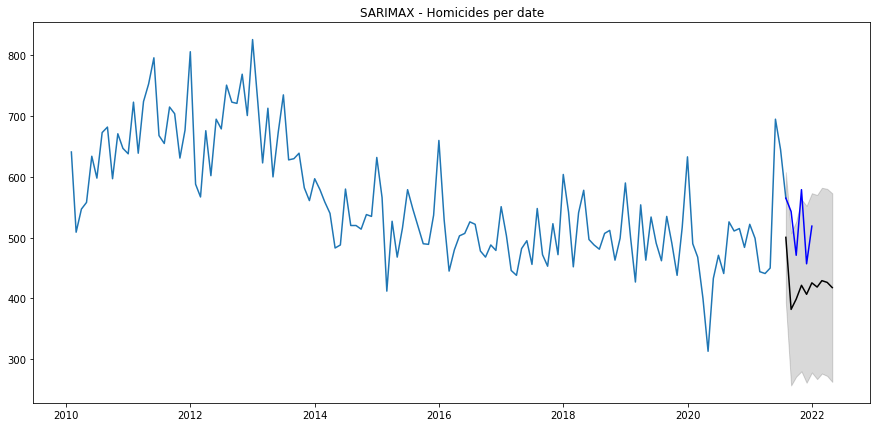

In [110]:
def sarimax_forecast(SARIMAX_model, periods):
    # Forecast
    n_periods = periods

    forecast_df = pd.DataFrame({"month_index":pd.date_range(train.index[-1], 
                                periods = n_periods, 
                                freq='W').week},
                                index = pd.date_range(train.index[-1], 
                                        periods = n_periods, 
                                        freq='W'))

    fitted, confint = SARIMAX_model.predict(n_periods=n_periods, 
                                            return_conf_int=True,
                                            exogenous=forecast_df[['month_index']],
                                            dynamic=True)

    index_of_fc = pd.date_range(train.index[-1], periods = n_periods, freq='W')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)



    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(train["total"], color='#1f76b4')
    plt.plot(fitted_series, color='black')
    plt.plot(test["total"], color='blue')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)
    
    plt.title("SARIMAX - Homicides per date")
    plt.show()

sarimax_forecast(SARIMAX_model,10)

In [ ]:
# Forecast Total
n_periods = 5

forecast_df = pd.DataFrame({"month_index":pd.date_range(train.index[-1], 
                            periods = n_periods, 
                            freq='M').month},
                            index = pd.date_range(train.index[-1], 
                                    periods = n_periods, 
                                    freq='M'))

fitted, confint = SARIMAX_model.predict(n_periods=n_periods, 
                                        return_conf_int=True,
                                        exogenous=forecast_df[['month_index']],
                                        dynamic=True)

index_of_fc = pd.date_range(train.index[-1], periods = n_periods, freq='M')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)


""" randnums_week = [115, 96, 120, 105 , 126, 127, 106, 130, 115, 100, 140, 100, 115, 106, 97, 128, 130, 100, 135, 85]
randnums_month = [540, 480, 610, 465 , 546]

df_d = pd.DataFrame(randnums_month, index = pd.date_range(train.index[-1], 
                                    periods = n_periods, 
                                    freq='M')) """

# Plot
plt.figure(figsize=(15,7))
plt.plot(df["total"], color='#1f76b4')
#plt.plot(df_d, color='darkgreen')
# plt.plot(df["total"], color='black')
plt.plot(test["total"], color='blue')
plt.fill_between(lower_series.index, 
                lower_series, 
                upper_series, 
                color='k', alpha=.15)

plt.title("SARIMAX")
plt.show()

In [ ]:
n_periods=4
forecast_df = pd.DataFrame({"month_index":pd.date_range(df.index[-1], 
                                periods = n_periods, 
                                freq='M').month},
                                index = pd.date_range(df.index[-1], 
                                        periods = n_periods, 
                                        freq='M'))

forecast_df

In [98]:
n_periods=6
forecast_df = pd.DataFrame({"month_index":pd.date_range(train.index[-1], 
                                periods = n_periods, 
                                freq='M').month},
                                index = pd.date_range(train.index[-1], 
                                        periods = n_periods, 
                                        freq='M'))
forecast_df


,month_index
2021-07-31,7
2021-08-31,8
2021-09-30,9
2021-10-31,10
2021-11-30,11
2021-12-31,12
